In [1]:
from matplotlib.pylab import *
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
π = pi

In [2]:
style.use(['dark_background', 'bmh'])
%matplotlib notebook

Car-trailer diagram (inverted image `car-trainer-k.png` available as well):
![car-trailer](car-trailer-w.png)

Car-trailer equation:
\begin{align}
\dot x &= s \cos \theta_0 \\
\dot y &= s \sin \theta_0 \\
\dot \theta_0 &= \frac{s}{L} \tan \phi \\
\dot \theta_1 &= \frac{s}{d_1} \sin(\theta_1 - \theta_0)
\end{align}
where $s$: signed speed, $\phi$: negative steering angle,

In [3]:
class Truck:
    def __init__(self, display=False):

        self.W = 1  # car and trailer width, for drawing only
        self.L = 1 * self.W  # car length
        self.d = 4 * self.L  # d_1
        self.s = -0.1  # speed
        self.display = display
        
        self.box = [0, 40, -10, 10]
        if self.display:
            self.f = figure(figsize=(10, 5), num='The truck backer-upper', facecolor='none')
            self.ax = self.f.add_axes([0.01, 0.01, 0.98, 0.98], facecolor='black')
            self.patches = list()
            
            self.ax.axis('equal')
            b = self.box
            self.ax.axis([b[0] - 1, b[1], b[2], b[3]])
            self.ax.set_xticks([], []); self.ax.set_yticks([], [])
            self.ax.axhline(); self.ax.axvline()

        self.reset()
    
    
    def set_state(self, x=None, y=None, θ0=None, θ1=None, ϕ=0):

        self.ϕ = ϕ  # car initial steering angle
        
        self.θ0 = θ0 
        self.θ1 = θ1 
        self.x = x 
        self.y = y 

        # Draw, if display is True
        if self.display: self.draw()
    
    
    def reset(self, x=None, y=None, θ0=None, θ1=None, ϕ=0):
        self.ϕ = ϕ  # car initial steering angle
        
        # self.θ0 = deg2rad(30)  # car initial direction
        # self.θ1 = deg2rad(-30)  # trailer initial direction
        # self.x, self.y = 20, -5  # initial car coordinates
        
        self.θ0 = θ0 if θ0 else random() * 2 * π  # 0 <= ϑ₀ < 2π
        self.θ1 = θ1 if θ1 else (random() - 0.5) * π / 2 + self.θ0  # -π/4 <= ϑ₁ - ϑ₀ < π/4
        self.x = x if x else (random() * .75 + 0.25) * self.box[1]
        self.y = y if y else (random() - 0.5) * (self.box[3] - self.box[2])
        
        # If poorly initialise, then re-initialise
        if not self.valid():
            self.reset(ϕ)
        
        # Draw, if display is True
        if self.display: self.draw()
    
    def step(self, ϕ=0, dt=1):
        
        # Check for illegal conditions
        if self.is_jackknifed():
#             print('The truck is jackknifed!')
            return
        
        if self.is_offscreen():
            print('The car or trailer is off screen')
            return
        
        self.ϕ = ϕ
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        
        # Perform state update
        self.x += s * cos(θ0) * dt
        self.y += s * sin(θ0) * dt
        self.θ0 += s / L * tan(ϕ) * dt
        self.θ1 += s / d * sin(θ0 - θ1) * dt
        
        return (self.x, self.y, self.θ0, *self._traler_xy(), self.θ1)
    
    def state(self):
        return (self.x, self.y, self.θ0, *self._traler_xy(), self.θ1)
    
    def _get_atributes(self):
        return (
            self.x, self.y, self.W, self.L, self.d, self.s,
            self.θ0, self.θ1, self.ϕ
        )
    
    def _traler_xy(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        return x - d * cos(θ1), y - d * sin(θ1)
        
    def is_jackknifed(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        return abs(θ0 - θ1) * 180 / π > 90
    
    def is_offscreen(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        
        x1, y1 = x + 1.5 * L * cos(θ0), y + 1.5 * L * sin(θ0)
        x2, y2 = self._traler_xy()
        
        b = self.box
        return not (
            b[0] <= x1 <= b[1] and b[2] <= y1 <= b[3] and
            b[0] <= x2 <= b[1] and b[2] <= y2 <= b[3]
        )
        
    def valid(self):
        return not self.is_jackknifed() and not self.is_offscreen()
        
    def draw(self):
        if not self.display: return
        if self.patches: self.clear()
        self._draw_car()
        self._draw_trailer()
        self.f.canvas.draw()
            
    def clear(self):
        for p in self.patches:
            p.remove()
        self.patches = list()
        
    def _draw_car(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        ax = self.ax
        
        x1, y1 = x + L / 2 * cos(θ0), y + L / 2 * sin(θ0)
        bar = Line2D((x, x1), (y, y1), lw=5, color='C2', alpha=0.8)
        ax.add_line(bar)

        car = Rectangle(
            (x1, y1 - W / 2), L, W, 0, color='C2', alpha=0.8, transform=
            matplotlib.transforms.Affine2D().rotate_deg_around(x1, y1, θ0 * 180 / π) +
            ax.transData
        )
        ax.add_patch(car)

        x2, y2 = x1 + L / 2 ** 0.5 * cos(θ0 + π / 4), y1 + L / 2 ** 0.5 * sin(θ0 + π / 4)
        left_wheel = Line2D(
            (x2 - L / 4 * cos(θ0 + ϕ), x2 + L / 4 * cos(θ0 + ϕ)),
            (y2 - L / 4 * sin(θ0 + ϕ), y2 + L / 4 * sin(θ0 + ϕ)),
            lw=3, color='C5', alpha=1)
        ax.add_line(left_wheel)

        x3, y3 = x1 + L / 2 ** 0.5 * cos(π / 4 - θ0), y1 - L / 2 ** 0.5 * sin(π / 4 - θ0)
        right_wheel = Line2D(
            (x3 - L / 4 * cos(θ0 + ϕ), x3 + L / 4 * cos(θ0 + ϕ)),
            (y3 - L / 4 * sin(θ0 + ϕ), y3 + L / 4 * sin(θ0 + ϕ)),
            lw=3, color='C5', alpha=1)
        ax.add_line(right_wheel)
        
        self.patches += [car, bar, left_wheel, right_wheel]
        
    def _draw_trailer(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        ax = self.ax
            
        x, y = x - d * cos(θ1), y - d * sin(θ1) - W / 2
        trailer = Rectangle(
            (x, y), d, W, 0, color='C0', alpha=0.8, transform=
            matplotlib.transforms.Affine2D().rotate_deg_around(x, y + W/2, θ1 * 180 / π) +
            ax.transData
        )
        ax.add_patch(trailer)
        
        self.patches += [trailer]

In [4]:
truck = Truck()

In [5]:
ϕ = deg2rad(-35)  # positive left, negative right
truck.step(ϕ)
truck.draw()

<IPython.core.display.Javascript object>


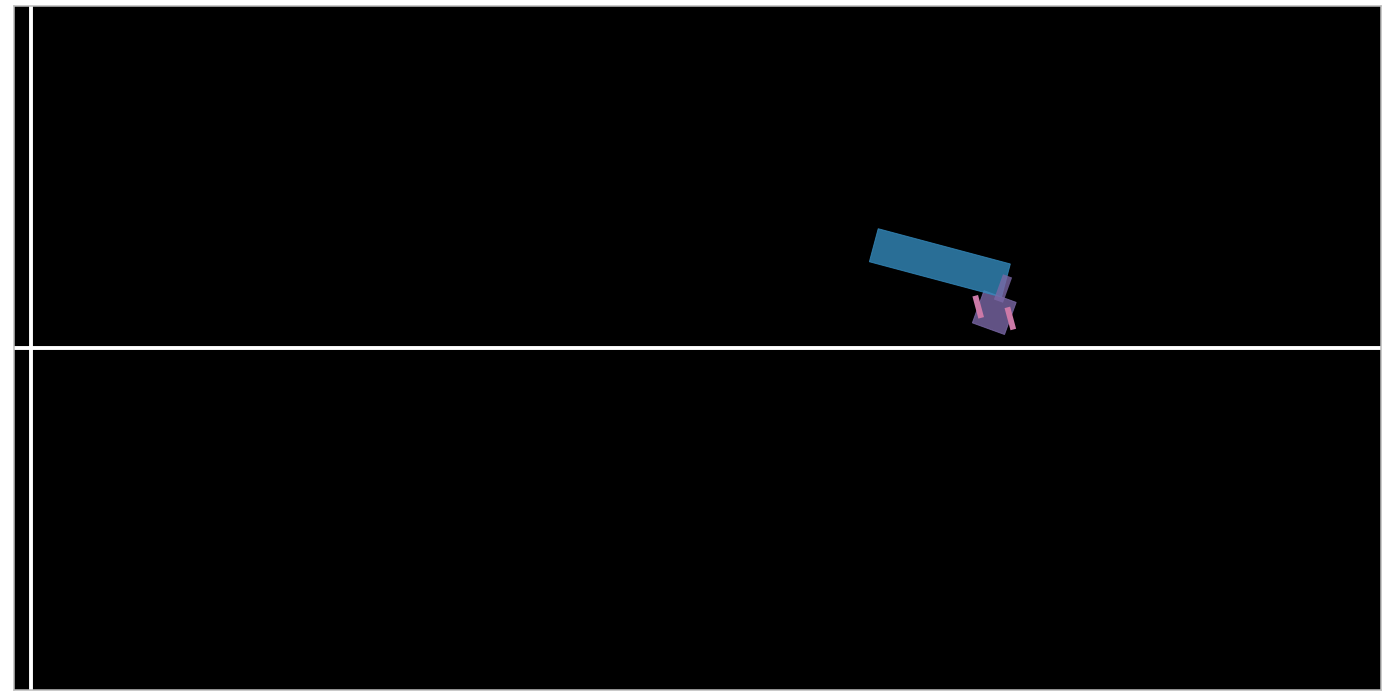

In [486]:
truck = Truck(display=True)
truck.reset()

In [ ]:
# load the model 
path = "truck_model_100.pth"
truck_model.load_state_dict(torch.load(path))

In [532]:
# run the sequence to watch the truck park itself
truck.reset()
controller.eval()
emulator.eval()

start_x = 30
start_y = -0.25
start_θ0 = -30
start_θ1 = -30

x = start_x + random()
y = start_y + random() * start_y * -2
θ0 = deg2rad(start_θ0 + random() * start_θ0 * -2)
θ1 = deg2rad(start_θ1 + random() * start_θ1 * -2) 

truck.set_state(x, y, θ0, θ1)

def get_control(ϕ=None):

    ϕ = ϕ if ϕ is not None else truck.state()
    print(ϕ[:6])
    ϕ = torch.tensor(ϕ).to(device)
    target = torch.tensor([0.,0.,0.]).to(device)
    with torch.no_grad():
        control = controller(ϕ)
        next_predicted_φ_state = emulator(torch.cat([control, ϕ]))
#         print(f"predicted state {next_predicted_φ_state}")
    distance_to_goal = criterion(next_predicted_φ_state[2:5], target).item()
    print(f"{distance_to_goal} remaining")
                                            
    return control



ϕ = None
step_count = 0 
sequence_count = 0
sequence_theshold =  1
step_distance = 1
control = get_control(ϕ)


while truck.valid():
    steering_angle = control.item()
    ϕ = truck.step(steering_angle, step_distance)

    truck.draw()
    step_count += 1


    control = get_control(ϕ)


print(f"actual final state: {truck.state()} in {step_count} steps")

(30.46115841627828, -0.16800172677751096, 0.02658261871390473, 26.91985036057137, 1.6918738751339004, -0.4835994831710808)
235.87559509277344 remaining
(30.361193745978657, -0.17065967558954268, -0.019314503016420556, 26.84285514339628, 1.7323099714565446, -0.49580788735127423)
234.52777099609375 remaining
(30.26121239790014, -0.16872834537359183, -0.06551513909112977, 26.764925303873945, 1.7744588705543665, -0.5072745371644647)
233.17413330078125 remaining
(30.161426932820014, -0.16218151722993746, -0.11207074558402882, 26.6861084487005, 1.8182632393682512, -0.5179628027478187)
231.8160400390625 remaining
(30.062054268404744, -0.15099788780964757, -0.15903217154356464, 26.60645367153697, 1.8636545673118474, -0.5278337651319771)
230.4547119140625 remaining
(29.963316167036577, -0.13516162126069198, -0.20644971728110373, 26.526012610354428, 1.910552009534257, -0.5368462117692699)
229.0914764404297 remaining
(29.865439682940885, -0.11466299054873001, -0.25437267522193074, 26.444840659104

In [74]:
print(truck.state())
print(truck.is_jackknifed())



(31.146542299459252, 6.1607508286186174, 5.705657563827013, 28.326189111012486, 8.997228907578183, 5.494936635065013)
False


In [7]:
import torch
import torch.nn as nn
from torch.optim import SGD
from tqdm import tqdm
from torch.autograd import Variable

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

In [8]:
truck = Truck();

In [76]:
# Build expert data set

# episodes = 10
inputs = list()
outputs = list()
truck = Truck(); episodes = 10_000  # uncooment for creating the data set

for episode in tqdm(range(episodes)):
    
    truck.reset()
    
    while truck.valid():
        initial_state = truck.state()
        ϕ = (random() - 0.5) * π / 2
        inputs.append((ϕ, *initial_state))
        outputs.append(truck.step(ϕ))
        truck.draw()

100%|██████████| 10000/10000 [00:16<00:00, 593.08it/s]


In [95]:
len(inputs), len(outputs)

(598416, 598416)

In [272]:
state_size = 6
steering_size = 1
hidden_units_e = 45

emulator = nn.Sequential(
    nn.Linear(steering_size + state_size, hidden_units_e),
    nn.ReLU(),
    nn.Linear(hidden_units_e, state_size)
)

optimiser_e = SGD(emulator.parameters(), lr=0.005)
criterion = nn.MSELoss()

emulator = emulator.to(device)

In [78]:
tensor_inputs = torch.Tensor(inputs)
tensor_outputs = torch.Tensor(outputs)

In [10]:
tensor_inputs = torch.load('tensor_inputs.pt')
tensor_outputs = torch.load('tensor_outputs.pt')

In [15]:
# torch.save(tensor_inputs, 'tensor_inputs.pt')
# torch.save(tensor_outputs, 'tensor_outputs.pt')

In [79]:
mean = tensor_inputs.mean(0)
std = tensor_inputs.std(0)
tensor_inputs = (tensor_inputs - mean) / std
tensor_outputs = (tensor_outputs - mean[1:]) / std[1:]

In [11]:
# Split the data into 80:20 for test:train.
test_size = int(len(tensor_inputs) * 0.8)
print(len(tensor_inputs), test_size)

train_inputs = tensor_inputs[:test_size]
train_outputs = tensor_outputs[:test_size]
test_inputs = tensor_inputs[test_size:]
test_outputs = tensor_outputs[test_size:]

5977851 4782280


In [276]:
train_inputs = torch.load('train_inputs.pt')
train_outputs = torch.load('train_outputs.pt')
test_inputs = torch.load('test_inputs.pt')
test_outputs = torch.load('test_outputs.pt')


# torch.save(train_inputs, 'train_inputs.pt')
# torch.save(train_outputs, 'train_outputs.pt')
# torch.save(test_inputs, 'test_inputs.pt')
# torch.save(test_outputs, 'test_outputs.pt')

# train_inputs = Variable(train_inputs.to(device), requires_grad=True) # add gradients so that we can backprop
# train_outputs = Variable(train_outputs.to(device), requires_grad=True)

train_inputs = train_inputs.to(device)
train_outputs = train_outputs.to(device)
test_inputs = test_inputs.to(device)
test_outputs = test_outputs.to(device)

In [277]:
len(train_inputs)

478732

In [83]:
# Train... BUG! Can you spot it?
# What is one of the main assumptions for training a net?


cnt = 0
for i in torch.randperm(len(train_inputs)):
    ϕ_state = train_inputs[i]
    next_state_prediction = emulator(ϕ_state)
    
    next_state = train_outputs[i]
    loss = criterion(next_state_prediction, next_state)
    
    optimiser_e.zero_grad()
    loss.backward()
    optimiser_e.step()
    
    if cnt == 0 or (cnt + 1) % 1000 == 0:
        print(f'{cnt + 1:4d} / {len(train_inputs)}, {loss.item():.10f}')
    cnt += 1

   1 / 487866, 1.9189869165
1000 / 487866, 0.1046412066
2000 / 487866, 0.0291699748
3000 / 487866, 0.0185969789
4000 / 487866, 0.0206762124
5000 / 487866, 0.0107163712
6000 / 487866, 0.0085765896
7000 / 487866, 0.0309939831
8000 / 487866, 0.0296340045
9000 / 487866, 0.0074120858
10000 / 487866, 0.0043150405
11000 / 487866, 0.0091394288
12000 / 487866, 0.0095119961
13000 / 487866, 0.0164935738
14000 / 487866, 0.0195971765
15000 / 487866, 0.0023762344
16000 / 487866, 0.0022691519
17000 / 487866, 0.0175016448
18000 / 487866, 0.0020279810
19000 / 487866, 0.0020351408
20000 / 487866, 0.0047998377
21000 / 487866, 0.0010603111
22000 / 487866, 0.0019715598
23000 / 487866, 0.0011329530
24000 / 487866, 0.0044500246
25000 / 487866, 0.0014829222
26000 / 487866, 0.0064623631
27000 / 487866, 0.0082889237
28000 / 487866, 0.0005289050
29000 / 487866, 0.0029300002
30000 / 487866, 0.0016334271
31000 / 487866, 0.0044028950
32000 / 487866, 0.0062261405
33000 / 487866, 0.0016019018
34000 / 487866, 0.003899

277000 / 487866, 0.0001592159
278000 / 487866, 0.0008160598
279000 / 487866, 0.0004551532
280000 / 487866, 0.0002146543
281000 / 487866, 0.0000390433
282000 / 487866, 0.0001123117
283000 / 487866, 0.0000784528
284000 / 487866, 0.0006483194
285000 / 487866, 0.0001756745
286000 / 487866, 0.0002306773
287000 / 487866, 0.0000966100
288000 / 487866, 0.0000858375
289000 / 487866, 0.0001477391
290000 / 487866, 0.0001175530
291000 / 487866, 0.0005418852
292000 / 487866, 0.0003630506
293000 / 487866, 0.0000515154
294000 / 487866, 0.0008538153
295000 / 487866, 0.0004609176
296000 / 487866, 0.0000069588
297000 / 487866, 0.0002539175
298000 / 487866, 0.0001056325
299000 / 487866, 0.0004016358
300000 / 487866, 0.0000882415
301000 / 487866, 0.0001851793
302000 / 487866, 0.0002760347
303000 / 487866, 0.0002685354
304000 / 487866, 0.0001923317
305000 / 487866, 0.0002741308
306000 / 487866, 0.0002120979
307000 / 487866, 0.0005276941
308000 / 487866, 0.0001233149
309000 / 487866, 0.0004365543
310000 / 4

In [289]:
# load the emulator model
path = "emulator-model.pth"
emulator.load_state_dict(torch.load(path))
emulator.eval()

Sequential(
  (0): Linear(in_features=7, out_features=45, bias=True)
  (1): ReLU()
  (2): Linear(in_features=45, out_features=6, bias=True)
)

In [290]:
# path = "emulator-new.pth"
# torch.save(emulator.state_dict(), path)

In [291]:
# Test

emulator.eval()
emulator_validation_loss = 0
with torch.no_grad():
    for idx, ϕ_state in enumerate(test_inputs):
        next_state_prediction = emulator(ϕ_state)
        
        next_state = test_outputs[idx]
        emulator_validation_loss += criterion(next_state_prediction, next_state).item()

    

In [292]:
print(f'Test loss: {emulator_validation_loss:.10f}')

Test loss: 14.3075155239


In [346]:
state_size = 6
steering_size = 1
hidden_units_c = 25

class HalfPiSigmoid(nn.Module):
    """Returns Sigmoid with the range -pi/2 to pi/2 """
    def forward(self, x):
        return (torch.sigmoid(x) - 0.5) * pi



controller = nn.Sequential(
    nn.Linear(state_size, hidden_units_c),
    nn.ReLU(),
    nn.Linear(hidden_units_c, steering_size),
    HalfPiSigmoid()
)

# optimiser_c = SGD(emulator.parameters(), lr=0.005)
optimiser_c = torch.optim.Adam(emulator.parameters(), lr=0.01)
criterion_c = nn.MSELoss()

controller = controller.to(device)

In [17]:
path = "controller-new.pth"
controller.load_state_dict(torch.load(path))
controller.eval()

Sequential(
  (0): Linear(in_features=6, out_features=25, bias=True)
  (1): ReLU()
  (2): Linear(in_features=25, out_features=1, bias=True)
  (3): HalfPiSigmoid()
)

In [89]:
# # save the pretrained controller model
# path = "controller-new.pth"
# torch.save(controller.state_dict(), path)

In [ ]:
# training code using just the controller and emulator
truck = Truck()
emulator.eval()
controller.train()

target = torch.tensor([0, 0, 0]).type(torch.float).to(device)
cnt = 0

running_loss = 0
last_running_loss = inf
running_step_count = 0
steps = 0
batch_steps = 0
early_stop_threshold = 5
successful_runs = 0
jackknifes = 0
start_x = 6.5
start_y = -0.25
start_θ0 = -30
start_θ1 = -30

# start_x = 6.25
# start_y = -2.25
# start_θ0 = -9
# start_θ1 = -9



while start_x <= 20:

    batch_steps += steps
    steps = 0
    emulator_steps = 0
    truck_steps = 0

    stop_conditions = False
    x = start_x + random()
    y = start_y + random() * start_y * -2
    θ0 = deg2rad(start_θ0 + random() * start_θ0 * -2)
    θ1 = deg2rad(start_θ1 + random() * start_θ1 * -2) 

    truck.set_state(x=x, y=y,θ0=θ0, θ1=θ1 )
#         print(truck.state())

#         ϕ_state = train_inputs[i][1:]
    ϕ_state = torch.tensor(truck.state(), requires_grad=True).to(device)
    initial_ϕ_state = ϕ_state.clone()

    if not truck.valid():
        print ("invalid start")
        continue


    start_state = f"({ϕ_state[3].item():.2f},{ϕ_state[4].item():.2f},{ϕ_state[5].item():.2f})"
    last_ϕ_state = ϕ_state
    last_actual_ϕ_state = ϕ_state

    sum_loss = 0
    moves_inside_dock = 0 
    step_distance = 0.25



    # next we'll compare the emulated postion to the actual position of our truck

    loss_controller = 0
    loss_actual = 0

    best_loss = inf

#         x, y, θ0, x2, y2, θ1 = ϕ_state.clone().detach().cpu().numpy()
#         truck.set_state(x, y, θ0, θ1)
# #         truck.draw()

    stop_conditions = False
    docked = False
    loss_controller = 0


    while truck.valid():
        x, y, θ0, x2, y2, θ1 = ϕ_state.clone().detach()
#             truck.set_state(x, y, θ0, θ1)
#             print(f"truck state {truck.state()}")

#             print(f"control {control}")
        truck_ϕ_state = torch.tensor(truck.state(), requires_grad=True).to(device)

#             predicted_steering_control = controller(truck_ϕ_state)
        predicted_steering_control = controller(ϕ_state)
        control = predicted_steering_control.clone().detach().cpu().item()
#             print(f"truck state {truck_ϕ_state}")
#             print(f"predicted control {control}")
        next_truck_ϕ_state = torch.tensor(truck.step(control), requires_grad=True).to(device)
        truck.draw()
#             print(f"next truck state {next_truck_ϕ_state}")
        steps += 1
        if truck.valid():
            ϕ_state = emulator(torch.cat([predicted_steering_control, truck_ϕ_state]))
#                 print(f"emulated state {ϕ_state} ")
#             loss_controller += criterion_c(ϕ_state[3:], target) ** 2   # make it to the target
            loss_controller += criterion_c(θ0, θ1) ** 2  # don't jackknife
#                 loss_controller += criterion_c(next_truck_ϕ_state[3:], target)
            loss_controller += criterion_c(ϕ_state, next_truck_ϕ_state)
            loss_controller /= steps
#                 print(loss_controller)
    if steps > 1:    
        loss_controller += criterion_c(next_truck_ϕ_state[3:], target)  #actual position
        loss_controller += criterion_c(θ0, θ1) ** 2  # don't jackknife



    actual_final_state = f"({next_truck_ϕ_state[0].item():.2f},{next_truck_ϕ_state[1].item():.2f},{next_truck_ϕ_state[2].item():.2f}, {next_truck_ϕ_state[3].item():.2f},{next_truck_ϕ_state[4].item():.2f},{next_truck_ϕ_state[5].item():.2f})"
    predicted_final_state = f"({ϕ_state[3].item():.2f},{ϕ_state[4].item():.2f},{ϕ_state[5].item():.2f})"





    jackknifed = truck.is_jackknifed()
    offscreen = truck.is_offscreen()

    loss_target = 6


    if loss_controller < loss_target:
        successful_runs += 1

    if jackknifed:
        jackknifes += 1


    controller.zero_grad()
    emulator.zero_grad()

    if loss_controller == 0:
        print("No Loss")
        continue

    final_loss = loss_controller.item()
    loss_controller.backward()

    optimiser_c.step()



    running_loss += final_loss
    running_step_count += steps

    display_threshold = 1000

    if cnt == 0 or (cnt + 1) % display_threshold == 0:
        print(f'{cnt + 1:3d}, item loss: {final_loss:.3f}, steps: {steps:3d}, start state: {start_state}, predicted final state: {predicted_final_state}, actual final state: {actual_final_state}, θ0, θ1: {θ0},{θ1} last move: {control:.3f}, docked: {docked}, jackknifed: {jackknifed}, offscreen: {offscreen}')
    cnt += 1

    summary_threshold = 2_000

    if (cnt + 1) % summary_threshold == 0:
        print(f"\n\nSuccess rate: {successful_runs} / {summary_threshold}, avg loss: {running_loss/summary_threshold:.3f}, avg steps:  {running_step_count/summary_threshold:2f} jackknifes: {jackknifes}")


        if running_loss > last_running_loss:
            early_stop_count += 1
        else:
            early_stop_count = 0

        print(f"\nEarly Stop: {early_stop_count} / {early_stop_threshold}\n\n")
        # scheduler
        avg_loss = running_loss/summary_threshold
        if avg_loss < loss_target:
            early_stop_count = 0
            start_x += 0.25
#             start_y -= 0.25
#             start_θ0 -= 1
#             start_θ1 -= 1
            print(f"Avg. loss is {avg_loss}. Increasing starting position to {start_x}, {start_y}\n\n")



        if early_stop_count > early_stop_threshold:
            break

        last_running_loss = running_loss
        running_loss = 0
        running_step_count = 0
        successful_runs = 0
        jackknifes = 0
    

  1, item loss: 11.691, steps:  33, start state: (3.51,0.20,-0.09), predicted final state: (1.69,0.42,-0.81), actual final state: (4.76,-1.95,0.86, 1.75,0.68,-0.72), θ0, θ1: 0.9726824164390564,-0.808030366897583 last move: -0.194, docked: False, jackknifed: True, offscreen: False
1000, item loss: 12.968, steps:  81, start state: (3.06,1.65,-0.49), predicted final state: (0.50,5.69,-1.60), actual final state: (-0.92,1.99,-0.46, 0.92,5.54,-2.05), θ0, θ1: -0.5846405029296875,-1.5952012538909912 last move: -0.121, docked: False, jackknifed: True, offscreen: False


Success rate: 1098 / 2000, avg loss: 6.317, avg steps:  42.940500 jackknifes: 864

Early Stop: 0 / 5


2000, item loss: 10.316, steps:  34, start state: (3.75,-1.90,0.51), predicted final state: (1.48,-3.11,0.17), actual final state: (5.30,-2.38,1.78, 1.38,-3.16,0.20), θ0, θ1: 1.7499374151229858,0.174221470952034 last move: -0.572, docked: False, jackknifed: True, offscreen: False
3000, item loss: 12.287, steps:  34, start state

25000, item loss: 4.402, steps:  54, start state: (2.94,-1.03,0.24), predicted final state: (0.12,-3.42,0.90), actual final state: (1.57,0.26,0.32, -0.03,-3.41,1.16), θ0, θ1: 0.3790459632873535,0.8987628221511841 last move: -0.116, docked: False, jackknifed: False, offscreen: True


Success rate: 1006 / 2000, avg loss: 6.616, avg steps:  45.466000 jackknifes: 910

Early Stop: 1 / 5


26000, item loss: 0.022, steps:  29, start state: (2.80,0.07,-0.04), predicted final state: (0.10,0.22,-0.01), actual final state: (3.92,-0.22,0.26, -0.06,0.20,-0.11), θ0, θ1: 0.23727667331695557,-0.014543682336807251 last move: -0.157, docked: False, jackknifed: False, offscreen: True
27000, item loss: 3.541, steps:  41, start state: (3.44,-1.14,0.25), predicted final state: (-0.04,-2.19,0.13), actual final state: (3.96,-1.85,1.33, -0.03,-2.20,0.09), θ0, θ1: 1.3059873580932617,0.13271749019622803 last move: -0.480, docked: False, jackknifed: False, offscreen: True


Success rate: 1021 / 2000, avg loss: 6.



Success rate: 1011 / 2000, avg loss: 6.642, avg steps:  44.946000 jackknifes: 948

Early Stop: 1 / 5


50000, item loss: 5.750, steps:  45, start state: (3.69,1.84,-0.50), predicted final state: (1.03,4.22,-0.35), actual final state: (4.79,2.71,-1.90, 0.93,3.76,-0.26), θ0, θ1: -1.275285243988037,-0.3537174463272095 last move: 0.372, docked: False, jackknifed: True, offscreen: False
51000, item loss: 5.574, steps:  45, start state: (3.53,1.60,-0.48), predicted final state: (0.15,3.88,-0.54), actual final state: (3.38,1.94,-1.06, -0.04,4.03,-0.55), θ0, θ1: -1.0298268795013428,-0.5376346111297607 last move: 0.177, docked: False, jackknifed: False, offscreen: True


Success rate: 1031 / 2000, avg loss: 6.719, avg steps:  45.799500 jackknifes: 889

Early Stop: 2 / 5


52000, item loss: 6.668, steps:  54, start state: (3.04,1.39,-0.30), predicted final state: (0.11,3.76,-1.26), actual final state: (1.59,0.32,-0.34, -0.02,3.98,-1.16), θ0, θ1: -0.28336000442504883,-1.2639051675796509 last mo

75000, item loss: 2.480, steps:  37, start state: (3.00,1.33,-0.29), predicted final state: (0.18,1.97,0.29), actual final state: (3.93,2.38,-1.00, -0.04,1.86,0.13), θ0, θ1: -0.7737295627593994,0.29185500741004944 last move: 0.220, docked: False, jackknifed: False, offscreen: True


Success rate: 1009 / 2000, avg loss: 6.453, avg steps:  45.019500 jackknifes: 923

Early Stop: 1 / 5


76000, item loss: 0.469, steps:  40, start state: (3.80,0.68,-0.23), predicted final state: (0.08,1.13,0.00), actual final state: (3.99,1.26,-0.43, -0.01,1.14,0.03), θ0, θ1: -0.4301948547363281,0.0010956376791000366 last move: 0.084, docked: False, jackknifed: False, offscreen: True
77000, item loss: 0.193, steps:  36, start state: (3.36,-0.08,0.05), predicted final state: (0.06,-0.61,0.34), actual final state: (3.80,0.48,0.11, -0.03,-0.69,0.30), θ0, θ1: 0.07269454002380371,0.3429452180862427 last move: -0.139, docked: False, jackknifed: False, offscreen: True


Success rate: 1033 / 2000, avg loss: 6.214, 



Success rate: 1002 / 2000, avg loss: 6.505, avg steps:  46.084500 jackknifes: 895

Early Stop: 0 / 5


100000, item loss: 2.108, steps:  34, start state: (3.12,1.27,-0.36), predicted final state: (0.13,2.46,-0.34), actual final state: (3.82,1.29,-0.73, -0.00,2.48,-0.30), θ0, θ1: -0.7253191471099854,-0.3370315432548523 last move: 0.163, docked: False, jackknifed: False, offscreen: True
101000, item loss: 3.651, steps:  37, start state: (3.10,-1.43,0.37), predicted final state: (0.05,-2.91,0.36), actual final state: (3.80,-1.66,1.29, -0.01,-2.87,0.31), θ0, θ1: 1.3176299333572388,0.3577660024166107 last move: -0.481, docked: False, jackknifed: False, offscreen: True


Success rate: 1009 / 2000, avg loss: 6.705, avg steps:  45.281500 jackknifes: 902

Early Stop: 1 / 5


102000, item loss: 0.623, steps:  40, start state: (3.83,0.66,-0.21), predicted final state: (0.05,1.36,-0.02), actual final state: (3.89,0.90,-0.34, -0.08,1.35,-0.11), θ0, θ1: -0.35567450523376465,-0.01777571439743042 la

125000, item loss: 5.946, steps:  49, start state: (3.76,-1.46,0.34), predicted final state: (0.03,-3.19,0.31), actual final state: (3.84,-2.33,1.65, -0.02,-3.38,0.27), θ0, θ1: 1.5049750804901123,0.30533522367477417 last move: -0.532, docked: False, jackknifed: False, offscreen: True


Success rate: 1043 / 2000, avg loss: 6.574, avg steps:  45.616500 jackknifes: 915

Early Stop: 2 / 5


126000, item loss: 3.281, steps:  44, start state: (3.76,-1.20,0.26), predicted final state: (0.01,-2.50,0.26), actual final state: (3.89,-1.77,1.27, -0.03,-2.61,0.21), θ0, θ1: 1.253487229347229,0.25742942094802856 last move: -0.480, docked: False, jackknifed: False, offscreen: True
127000, item loss: 9.304, steps:  46, start state: (4.11,-1.74,0.44), predicted final state: (0.81,-3.51,0.38), actual final state: (4.76,-2.69,1.88, 0.86,-3.60,0.23), θ0, θ1: 1.8430367708206177,0.3753034770488739 last move: -0.569, docked: False, jackknifed: True, offscreen: False


Success rate: 1017 / 2000, avg loss: 6.14



Success rate: 1034 / 2000, avg loss: 6.568, avg steps:  45.729500 jackknifes: 856

Early Stop: 0 / 5


150000, item loss: 11.965, steps:  31, start state: (4.17,-2.02,0.50), predicted final state: (2.13,-2.96,0.12), actual final state: (6.01,-2.44,1.77, 2.06,-3.05,0.15), θ0, θ1: 1.7564336061477661,0.115648552775383 last move: -0.574, docked: False, jackknifed: True, offscreen: False
151000, item loss: 17.303, steps:  41, start state: (4.08,1.64,-0.49), predicted final state: (1.29,4.02,-0.04), actual final state: (5.37,2.86,-1.62, 1.37,2.87,-0.00), θ0, θ1: -1.9616608619689941,-0.04088030382990837 last move: 0.301, docked: False, jackknifed: True, offscreen: False


Success rate: 1019 / 2000, avg loss: 6.533, avg steps:  45.363500 jackknifes: 906

Early Stop: 0 / 5


152000, item loss: 6.675, steps:  42, start state: (3.67,1.84,-0.43), predicted final state: (0.49,2.70,-0.04), actual final state: (4.74,3.27,-1.47, 0.76,2.82,0.11), θ0, θ1: -1.4265803098678589,-0.035931408405303955 last

175000, item loss: 6.183, steps:  46, start state: (3.52,1.78,-0.40), predicted final state: (0.06,4.08,-0.69), actual final state: (3.07,1.71,-0.86, -0.02,4.25,-0.69), θ0, θ1: -0.7550922632217407,-0.6873136162757874 last move: 0.168, docked: False, jackknifed: False, offscreen: True


Success rate: 1001 / 2000, avg loss: 6.673, avg steps:  45.768000 jackknifes: 922

Early Stop: 2 / 5


176000, item loss: 9.060, steps:  38, start state: (2.98,-1.17,0.25), predicted final state: (0.05,-1.78,-0.18), actual final state: (4.02,-2.34,1.43, 0.06,-1.74,-0.15), θ0, θ1: 1.4997280836105347,-0.17562086880207062 last move: -0.494, docked: False, jackknifed: True, offscreen: False
177000, item loss: 6.948, steps:  43, start state: (3.35,-0.18,-0.00), predicted final state: (0.31,0.02,-0.45), actual final state: (3.64,-2.00,1.01, 0.29,0.18,-0.58), θ0, θ1: 1.1554529666900635,-0.45093458890914917 last move: -0.297, docked: False, jackknifed: True, offscreen: False


Success rate: 1009 / 2000, avg loss



Success rate: 949 / 2000, avg loss: 6.488, avg steps:  45.232500 jackknifes: 933

Early Stop: 2 / 5


200000, item loss: 1.078, steps:  37, start state: (3.33,-0.78,0.21), predicted final state: (0.08,-1.29,0.09), actual final state: (3.99,-1.44,1.01, -0.01,-1.42,-0.01), θ0, θ1: 0.8839482665061951,0.0879659503698349 last move: -0.397, docked: False, jackknifed: False, offscreen: True
201000, item loss: 4.898, steps:  48, start state: (3.80,1.30,-0.38), predicted final state: (0.07,3.64,-0.75), actual final state: (3.15,1.36,-0.81, -0.04,3.78,-0.65), θ0, θ1: -0.8710113763809204,-0.7509986758232117 last move: 0.129, docked: False, jackknifed: False, offscreen: True


Success rate: 1038 / 2000, avg loss: 6.751, avg steps:  45.469500 jackknifes: 916

Early Stop: 3 / 5


202000, item loss: 0.011, steps:  30, start state: (2.97,0.20,0.00), predicted final state: (0.16,0.15,0.07), actual final state: (3.98,0.12,0.18, -0.02,0.16,-0.01), θ0, θ1: 0.2721238136291504,0.06929979473352432 last mov

225000, item loss: 9.274, steps:  33, start state: (3.45,0.89,-0.24), predicted final state: (2.31,1.37,-0.90), actual final state: (4.51,-1.74,0.63, 2.18,1.51,-0.95), θ0, θ1: 0.6985097527503967,-0.8950620889663696 last move: -0.078, docked: False, jackknifed: True, offscreen: False


Success rate: 996 / 2000, avg loss: 6.557, avg steps:  45.360500 jackknifes: 892

Early Stop: 0 / 5


226000, item loss: 0.586, steps:  35, start state: (3.37,0.71,-0.22), predicted final state: (0.08,1.33,0.02), actual final state: (3.96,0.94,-0.37, -0.03,1.27,-0.08), θ0, θ1: -0.4432729482650757,0.02430345118045807 last move: 0.067, docked: False, jackknifed: False, offscreen: True
227000, item loss: 13.139, steps:  82, start state: (3.17,1.37,-0.39), predicted final state: (1.10,4.71,-1.97), actual final state: (-0.88,1.24,-0.45, 0.94,4.80,-2.04), θ0, θ1: -0.582749605178833,-1.971595287322998 last move: -0.077, docked: False, jackknifed: True, offscreen: False


Success rate: 1022 / 2000, avg loss: 7.07



Success rate: 1001 / 2000, avg loss: 6.635, avg steps:  45.541000 jackknifes: 913

Early Stop: 0 / 5


250000, item loss: 0.447, steps:  36, start state: (3.50,0.49,-0.18), predicted final state: (0.07,1.05,-0.13), actual final state: (3.88,0.32,-0.09, -0.04,1.14,-0.21), θ0, θ1: -0.04713559150695801,-0.13251152634620667 last move: -0.018, docked: False, jackknifed: False, offscreen: True
251000, item loss: 7.285, steps:  45, start state: (3.39,0.59,-0.15), predicted final state: (1.57,1.60,-0.98), actual final state: (3.29,-1.98,0.53, 1.32,1.50,-1.06), θ0, θ1: 0.5448856353759766,-0.9841271042823792 last move: -0.064, docked: False, jackknifed: True, offscreen: False


Success rate: 970 / 2000, avg loss: 6.626, avg steps:  45.910000 jackknifes: 918

Early Stop: 0 / 5


252000, item loss: 0.224, steps:  30, start state: (2.77,0.60,-0.10), predicted final state: (0.04,0.66,0.19), actual final state: (3.89,1.10,-0.33, -0.08,0.61,0.12), θ0, θ1: -0.3512578010559082,0.19390317797660828 last

275000, item loss: 2.564, steps:  41, start state: (3.71,1.35,-0.35), predicted final state: (0.06,2.71,-0.19), actual final state: (3.88,1.82,-0.86, -0.03,2.69,-0.22), θ0, θ1: -0.7846840620040894,-0.18813319504261017 last move: 0.203, docked: False, jackknifed: False, offscreen: True


Success rate: 991 / 2000, avg loss: 6.583, avg steps:  44.838000 jackknifes: 951

Early Stop: 1 / 5


276000, item loss: 5.987, steps:  36, start state: (3.54,-0.61,0.16), predicted final state: (1.01,-0.69,-0.40), actual final state: (4.75,-2.13,1.21, 1.01,-0.70,-0.36), θ0, θ1: 1.1211841106414795,-0.39667144417762756 last move: -0.364, docked: False, jackknifed: True, offscreen: False
277000, item loss: 15.121, steps:  51, start state: (3.47,-1.96,0.46), predicted final state: (0.40,-4.26,0.38), actual final state: (4.01,-2.77,2.09, 0.38,-4.44,0.43), θ0, θ1: 2.0755746364593506,0.37868237495422363 last move: -0.590, docked: False, jackknifed: True, offscreen: False


Success rate: 1033 / 2000, avg loss:



Success rate: 1003 / 2000, avg loss: 6.434, avg steps:  45.373500 jackknifes: 914

Early Stop: 0 / 5


300000, item loss: 7.834, steps:  46, start state: (3.69,-1.83,0.42), predicted final state: (0.39,-3.78,0.36), actual final state: (4.31,-2.77,1.86, 0.41,-3.64,0.22), θ0, θ1: 1.7046163082122803,0.3587004840373993 last move: -0.573, docked: False, jackknifed: True, offscreen: False
301000, item loss: 4.486, steps:  39, start state: (3.10,-0.57,0.18), predicted final state: (0.11,-0.81,-0.23), actual final state: (4.06,-2.16,1.26, 0.32,-0.74,-0.36), θ0, θ1: 1.1989079713821411,-0.22680115699768066 last move: -0.400, docked: False, jackknifed: True, offscreen: False


Success rate: 1023 / 2000, avg loss: 6.438, avg steps:  45.161000 jackknifes: 883

Early Stop: 1 / 5


302000, item loss: 8.981, steps:  38, start state: (3.59,0.11,-0.03), predicted final state: (1.44,0.44,-0.85), actual final state: (4.43,-2.07,0.89, 1.44,0.58,-0.72), θ0, θ1: 0.8253750801086426,-0.8468259572982788 last 

325000, item loss: 7.149, steps:  33, start state: (3.31,-2.07,0.48), predicted final state: (1.04,-3.32,0.27), actual final state: (4.94,-2.59,1.75, 0.98,-3.18,0.15), θ0, θ1: 1.6281635761260986,0.27498167753219604 last move: -0.585, docked: False, jackknifed: True, offscreen: False


Success rate: 1035 / 2000, avg loss: 6.479, avg steps:  45.781000 jackknifes: 887

Early Stop: 0 / 5


326000, item loss: 0.130, steps:  33, start state: (3.15,-0.24,0.09), predicted final state: (0.03,-0.60,0.12), actual final state: (3.92,-0.41,0.49, -0.08,-0.59,0.05), θ0, θ1: 0.44471997022628784,0.12228991091251373 last move: -0.254, docked: False, jackknifed: False, offscreen: True
327000, item loss: 1.619, steps:  33, start state: (2.94,-1.20,0.25), predicted final state: (0.07,-1.84,0.25), actual final state: (3.89,-1.37,1.01, -0.04,-2.09,0.18), θ0, θ1: 0.8629539012908936,0.246609628200531 last move: -0.428, docked: False, jackknifed: False, offscreen: True


Success rate: 937 / 2000, avg loss: 6.67



Success rate: 1036 / 2000, avg loss: 6.477, avg steps:  45.285500 jackknifes: 904

Early Stop: 1 / 5


350000, item loss: 7.388, steps:  49, start state: (3.51,0.53,-0.11), predicted final state: (0.80,1.46,-0.99), actual final state: (3.03,-1.86,0.61, 0.83,1.48,-0.99), θ0, θ1: 0.5773812532424927,-0.9870363473892212 last move: -0.097, docked: False, jackknifed: True, offscreen: False
351000, item loss: 18.930, steps:  79, start state: (3.76,-1.65,0.47), predicted final state: (0.78,-6.35,1.32), actual final state: (3.19,-3.45,2.58, 0.80,-6.66,0.93), θ0, θ1: 2.6993227005004883,1.321099877357483 last move: -0.620, docked: False, jackknifed: True, offscreen: False


Success rate: 1002 / 2000, avg loss: 6.665, avg steps:  45.180500 jackknifes: 948

Early Stop: 2 / 5


352000, item loss: 14.248, steps:  68, start state: (3.51,-1.51,0.42), predicted final state: (0.01,-5.74,0.88), actual final state: (2.98,-2.89,2.14, -0.01,-5.55,0.73), θ0, θ1: 2.2710702419281006,0.8800325393676758 last mo

375000, item loss: 4.597, steps:  40, start state: (3.49,0.72,-0.19), predicted final state: (1.22,1.46,-0.81), actual final state: (3.86,-1.84,0.58, 1.72,1.54,-1.01), θ0, θ1: 0.4340512752532959,-0.8146282434463501 last move: -0.089, docked: False, jackknifed: True, offscreen: False


Success rate: 1017 / 2000, avg loss: 6.717, avg steps:  45.395500 jackknifes: 933

Early Stop: 1 / 5


376000, item loss: 0.039, steps:  32, start state: (3.17,0.17,-0.08), predicted final state: (0.13,0.42,-0.04), actual final state: (3.98,0.13,0.05, -0.02,0.34,-0.05), θ0, θ1: 0.042249202728271484,-0.03997782617807388 last move: -0.094, docked: False, jackknifed: False, offscreen: True
377000, item loss: 6.964, steps:  55, start state: (3.49,1.50,-0.32), predicted final state: (0.04,4.44,-1.01), actual final state: (2.06,1.03,-0.60, -0.03,4.45,-1.02), θ0, θ1: -0.6590243577957153,-1.010511875152588 last move: 0.097, docked: False, jackknifed: False, offscreen: True


Success rate: 1012 / 2000, avg loss: 6



Success rate: 1030 / 2000, avg loss: 6.392, avg steps:  45.570000 jackknifes: 881

Early Stop: 0 / 5


400000, item loss: 3.036, steps:  35, start state: (2.98,1.48,-0.34), predicted final state: (0.15,3.02,-0.35), actual final state: (3.44,1.03,-0.60, -0.06,2.97,-0.51), θ0, θ1: -0.6335246562957764,-0.3507491648197174 last move: 0.148, docked: False, jackknifed: False, offscreen: True
401000, item loss: 5.426, steps:  50, start state: (3.60,0.72,-0.19), predicted final state: (1.48,2.10,-1.07), actual final state: (2.87,-1.85,0.37, 1.45,1.89,-1.21), θ0, θ1: 0.2419898509979248,-1.0736465454101562 last move: -0.013, docked: False, jackknifed: True, offscreen: False


Success rate: 1045 / 2000, avg loss: 6.407, avg steps:  45.399500 jackknifes: 894

Early Stop: 1 / 5


402000, item loss: 10.537, steps:  53, start state: (3.58,-1.89,0.50), predicted final state: (0.13,-4.65,0.56), actual final state: (3.86,-2.88,2.06, 0.27,-4.65,0.46), θ0, θ1: 1.8972346782684326,0.5615406036376953 last m

425000, item loss: 0.194, steps:  37, start state: (3.35,0.19,-0.02), predicted final state: (0.03,-0.13,0.37), actual final state: (3.76,1.02,-0.18, -0.03,-0.25,0.32), θ0, θ1: -0.23160183429718018,0.3733828663825989 last move: -0.036, docked: False, jackknifed: False, offscreen: True


Success rate: 1012 / 2000, avg loss: 6.433, avg steps:  45.180500 jackknifes: 913

Early Stop: 0 / 5


426000, item loss: 0.534, steps:  31, start state: (2.90,-0.51,0.16), predicted final state: (0.06,-1.16,0.29), actual final state: (3.81,-0.18,0.44, -0.05,-1.24,0.27), θ0, θ1: 0.38754594326019287,0.2926846146583557 last move: -0.263, docked: False, jackknifed: False, offscreen: True
427000, item loss: 10.473, steps:  47, start state: (3.94,-1.72,0.47), predicted final state: (0.71,-3.78,0.36), actual final state: (4.54,-2.61,1.93, 0.73,-3.81,0.31), θ0, θ1: 1.8798015117645264,0.3606361746788025 last move: -0.566, docked: False, jackknifed: True, offscreen: False


Success rate: 997 / 2000, avg loss: 6.



Success rate: 970 / 2000, avg loss: 6.742, avg steps:  46.068000 jackknifes: 938

Early Stop: 1 / 5


450000, item loss: 10.331, steps:  68, start state: (3.05,1.26,-0.27), predicted final state: (0.39,3.47,-1.61), actual final state: (0.18,-0.44,0.00, 0.29,3.56,-1.60), θ0, θ1: -0.10519945621490479,-1.6118108034133911 last move: -0.101, docked: False, jackknifed: True, offscreen: False
451000, item loss: 8.089, steps:  44, start state: (3.18,1.74,-0.39), predicted final state: (0.23,2.58,0.12), actual final state: (4.11,3.43,-1.36, 0.21,2.55,0.22), θ0, θ1: -1.434787631034851,0.11503790318965912 last move: 0.202, docked: False, jackknifed: True, offscreen: False


Success rate: 984 / 2000, avg loss: 6.534, avg steps:  44.621500 jackknifes: 948

Early Stop: 0 / 5


452000, item loss: 2.148, steps:  41, start state: (3.67,1.17,-0.35), predicted final state: (0.04,2.20,-0.00), actual final state: (3.96,1.93,-0.87, -0.03,2.20,-0.07), θ0, θ1: -0.8521589040756226,-0.0023622214794158936 last

475000, item loss: 2.734, steps:  41, start state: (3.40,-1.07,0.31), predicted final state: (-0.01,-2.69,0.42), actual final state: (3.55,-1.09,1.07, -0.07,-2.78,0.43), θ0, θ1: 0.9762214422225952,0.4154026210308075 last move: -0.443, docked: False, jackknifed: False, offscreen: True


Success rate: 1005 / 2000, avg loss: 6.574, avg steps:  45.208000 jackknifes: 914

Early Stop: 1 / 5


476000, item loss: 21.072, steps:  82, start state: (3.54,-1.63,0.39), predicted final state: (0.11,-6.69,0.86), actual final state: (2.64,-3.55,2.54, 0.09,-6.63,0.88), θ0, θ1: 2.4332752227783203,0.8611194491386414 last move: -0.631, docked: False, jackknifed: True, offscreen: False
477000, item loss: 6.133, steps:  54, start state: (3.58,0.30,-0.07), predicted final state: (0.13,1.37,-0.93), actual final state: (2.59,-1.93,0.65, 0.23,1.30,-0.94), θ0, θ1: 0.5787885189056396,-0.9287995100021362 last move: -0.140, docked: False, jackknifed: True, offscreen: False


Success rate: 1025 / 2000, avg loss: 6.7



Success rate: 1017 / 2000, avg loss: 6.862, avg steps:  46.770000 jackknifes: 861

Early Stop: 2 / 5


500000, item loss: 7.747, steps:  60, start state: (3.80,0.76,-0.21), predicted final state: (1.25,2.44,-1.36), actual final state: (1.94,-1.67,0.17, 1.37,2.29,-1.43), θ0, θ1: 0.10950112342834473,-1.35735023021698 last move: 0.015, docked: False, jackknifed: True, offscreen: False
501000, item loss: 7.988, steps:  56, start state: (3.04,1.15,-0.26), predicted final state: (1.10,2.65,-1.46), actual final state: (1.57,-1.47,0.11, 1.20,2.51,-1.48), θ0, θ1: 0.0020329952239990234,-1.4620100259780884 last move: 0.018, docked: False, jackknifed: True, offscreen: False


Success rate: 993 / 2000, avg loss: 6.514, avg steps:  45.474500 jackknifes: 912

Early Stop: 0 / 5


502000, item loss: 8.082, steps:  45, start state: (3.27,-1.58,0.45), predicted final state: (0.05,-3.30,0.29), actual final state: (3.99,-2.54,1.83, 0.08,-3.35,0.20), θ0, θ1: 1.726395606994629,0.29098546504974365 last move

525000, item loss: 12.083, steps:  46, start state: (3.62,0.21,-0.09), predicted final state: (1.18,1.16,-1.25), actual final state: (3.47,-2.17,0.65, 1.15,1.08,-0.95), θ0, θ1: 0.5604422688484192,-1.2486404180526733 last move: -0.128, docked: False, jackknifed: True, offscreen: False


Success rate: 1041 / 2000, avg loss: 6.777, avg steps:  45.277500 jackknifes: 924

Early Stop: 1 / 5


526000, item loss: 6.809, steps:  30, start state: (3.08,-0.83,0.15), predicted final state: (1.10,-0.88,-0.37), actual final state: (4.88,-2.19,1.24, 1.10,-0.88,-0.33), θ0, θ1: 1.1879839897155762,-0.373193621635437 last move: -0.390, docked: False, jackknifed: True, offscreen: False
527000, item loss: 1.767, steps:  41, start state: (3.80,1.11,-0.32), predicted final state: (0.22,2.09,-0.16), actual final state: (3.87,1.51,-0.66, -0.05,2.29,-0.20), θ0, θ1: -0.44058895111083984,-0.16256126761436462 last move: 0.187, docked: False, jackknifed: False, offscreen: True


Success rate: 1006 / 2000, avg loss:



Success rate: 1014 / 2000, avg loss: 6.465, avg steps:  45.416000 jackknifes: 889

Early Stop: 0 / 5


550000, item loss: 7.000, steps:  28, start state: (3.51,-1.25,0.36), predicted final state: (1.85,-1.79,0.02), actual final state: (5.64,-1.92,1.58, 1.64,-1.81,-0.03), θ0, θ1: 1.508512258529663,0.023224718868732452 last move: -0.459, docked: False, jackknifed: True, offscreen: False
551000, item loss: 16.064, steps:  81, start state: (3.32,1.22,-0.29), predicted final state: (0.13,4.70,-1.65), actual final state: (-0.77,0.72,-0.22, 0.11,4.62,-1.79), θ0, θ1: 0.021916508674621582,-1.6479847431182861 last move: -0.111, docked: False, jackknifed: True, offscreen: False


Success rate: 988 / 2000, avg loss: 6.631, avg steps:  44.622500 jackknifes: 935

Early Stop: 1 / 5


552000, item loss: 2.846, steps:  36, start state: (3.15,-0.82,0.22), predicted final state: (0.67,-1.27,-0.14), actual final state: (4.42,-2.17,1.34, 0.56,-1.13,-0.26), θ0, θ1: 1.0822865962982178,-0.14158566296100616 

575000, item loss: 7.991, steps:  42, start state: (3.20,-1.66,0.46), predicted final state: (0.31,-3.26,0.40), actual final state: (4.13,-2.48,1.80, 0.22,-3.30,0.21), θ0, θ1: 1.8312156200408936,0.3955761790275574 last move: -0.538, docked: False, jackknifed: True, offscreen: False


Success rate: 984 / 2000, avg loss: 6.545, avg steps:  45.031500 jackknifes: 950

Early Stop: 1 / 5


576000, item loss: 0.684, steps:  33, start state: (3.02,-0.57,0.19), predicted final state: (0.02,-1.12,0.11), actual final state: (3.93,-0.96,0.82, -0.07,-1.13,0.04), θ0, θ1: 0.817192554473877,0.1104036346077919 last move: -0.350, docked: False, jackknifed: False, offscreen: True
577000, item loss: 8.264, steps:  40, start state: (3.33,-1.66,0.45), predicted final state: (0.46,-3.11,0.16), actual final state: (4.43,-2.46,1.79, 0.48,-3.08,0.15), θ0, θ1: 1.6486053466796875,0.159780815243721 last move: -0.552, docked: False, jackknifed: True, offscreen: False


Success rate: 990 / 2000, avg loss: 6.862, avg



Success rate: 994 / 2000, avg loss: 6.784, avg steps:  45.300500 jackknifes: 934

Early Stop: 1 / 5


600000, item loss: 7.640, steps:  43, start state: (3.40,-0.88,0.18), predicted final state: (-0.02,-1.52,-0.19), actual final state: (3.96,-2.20,1.40, 0.03,-1.45,-0.19), θ0, θ1: 1.4207557439804077,-0.19356375932693481 last move: -0.464, docked: False, jackknifed: True, offscreen: False
601000, item loss: 12.258, steps:  73, start state: (3.81,1.35,-0.36), predicted final state: (0.09,6.02,-1.32), actual final state: (1.07,2.07,-0.87, -0.01,5.92,-1.30), θ0, θ1: -0.9304057359695435,-1.3153507709503174 last move: 0.087, docked: False, jackknifed: False, offscreen: True


Success rate: 1031 / 2000, avg loss: 6.599, avg steps:  45.676000 jackknifes: 860

Early Stop: 0 / 5


602000, item loss: 18.152, steps:  73, start state: (4.03,-1.99,0.46), predicted final state: (1.24,-6.07,0.99), actual final state: (3.67,-3.26,2.54, 1.22,-6.42,0.91), θ0, θ1: 2.362942695617676,0.9855225086212158 las

625000, item loss: 0.552, steps:  36, start state: (3.49,0.69,-0.14), predicted final state: (0.14,1.18,-0.32), actual final state: (3.86,0.44,-0.07, -0.05,1.27,-0.21), θ0, θ1: -0.18368327617645264,-0.3155195415019989 last move: 0.009, docked: False, jackknifed: False, offscreen: True


Success rate: 1052 / 2000, avg loss: 6.464, avg steps:  45.468000 jackknifes: 866

Early Stop: 1 / 5


626000, item loss: 5.186, steps:  47, start state: (3.64,1.58,-0.46), predicted final state: (0.08,3.21,-0.10), actual final state: (3.98,2.87,-1.31, -0.01,3.23,-0.09), θ0, θ1: -1.2379136085510254,-0.10109599679708481 last move: 0.222, docked: False, jackknifed: False, offscreen: True
627000, item loss: 9.163, steps:  36, start state: (4.18,-1.84,0.49), predicted final state: (1.69,-3.18,0.23), actual final state: (5.56,-2.33,1.82, 1.67,-3.23,0.23), θ0, θ1: 1.6996397972106934,0.23197542130947113 last move: -0.571, docked: False, jackknifed: True, offscreen: False


Success rate: 989 / 2000, avg loss: 6



Success rate: 1029 / 2000, avg loss: 6.848, avg steps:  46.073500 jackknifes: 881

Early Stop: 1 / 5


650000, item loss: 6.048, steps:  41, start state: (3.11,-0.40,0.05), predicted final state: (0.21,-0.17,-0.51), actual final state: (3.69,-2.19,1.08, 0.23,-0.18,-0.53), θ0, θ1: 1.0403293371200562,-0.5117652416229248 last move: -0.333, docked: False, jackknifed: True, offscreen: False
651000, item loss: 5.982, steps:  33, start state: (3.26,-1.06,0.23), predicted final state: (0.85,-1.46,-0.11), actual final state: (4.79,-2.18,1.39, 0.85,-1.44,-0.19), θ0, θ1: 1.376416563987732,-0.11212942004203796 last move: -0.451, docked: False, jackknifed: True, offscreen: False


Success rate: 1017 / 2000, avg loss: 6.568, avg steps:  45.488500 jackknifes: 896

Early Stop: 0 / 5


652000, item loss: 5.861, steps:  35, start state: (3.01,-0.28,0.04), predicted final state: (0.83,-0.05,-0.56), actual final state: (4.26,-2.12,1.09, 0.83,-0.07,-0.54), θ0, θ1: 0.9644994735717773,-0.5595789551734924 l

675000, item loss: 6.735, steps:  49, start state: (3.36,1.55,-0.43), predicted final state: (0.26,4.23,-0.96), actual final state: (2.45,1.24,-0.74, -0.01,4.40,-0.91), θ0, θ1: -0.7905036211013794,-0.9595947861671448 last move: 0.120, docked: False, jackknifed: False, offscreen: True


Success rate: 1050 / 2000, avg loss: 6.417, avg steps:  45.468500 jackknifes: 850

Early Stop: 0 / 5


676000, item loss: 8.657, steps:  32, start state: (3.86,-2.04,0.48), predicted final state: (1.72,-2.96,0.23), actual final state: (5.61,-2.48,1.79, 1.66,-3.12,0.16), θ0, θ1: 1.6796157360076904,0.23320689797401428 last move: -0.571, docked: False, jackknifed: True, offscreen: False
677000, item loss: 10.372, steps:  80, start state: (3.77,1.08,-0.24), predicted final state: (0.73,3.81,-1.66), actual final state: (-0.22,0.03,-0.20, 0.64,3.94,-1.79), θ0, θ1: -0.24948585033416748,-1.658780574798584 last move: -0.058, docked: False, jackknifed: True, offscreen: False


Success rate: 1012 / 2000, avg loss: 



Success rate: 1023 / 2000, avg loss: 6.245, avg steps:  43.996500 jackknifes: 913

Early Stop: 0 / 5


700000, item loss: 0.014, steps:  38, start state: (3.68,0.20,-0.00), predicted final state: (0.07,-0.13,0.21), actual final state: (3.90,0.50,0.08, -0.05,-0.11,0.15), θ0, θ1: 0.04944872856140137,0.20717696845531464 last move: -0.110, docked: False, jackknifed: False, offscreen: True
701000, item loss: 34.756, steps: 113, start state: (3.91,1.58,-0.36), predicted final state: (0.50,10.05,-1.95), actual final state: (0.34,6.06,-1.44, 0.74,10.04,-1.67), θ0, θ1: -2.347628593444824,-1.9470291137695312 last move: 0.054, docked: False, jackknifed: False, offscreen: True


Success rate: 992 / 2000, avg loss: 6.551, avg steps:  44.843000 jackknifes: 950

Early Stop: 1 / 5


702000, item loss: 19.047, steps:  79, start state: (3.94,-1.54,0.34), predicted final state: (0.13,-6.18,0.75), actual final state: (3.01,-3.31,2.42, 0.13,-6.08,0.77), θ0, θ1: 2.347287178039551,0.7527773976325989 last m

725000, item loss: 10.423, steps:  64, start state: (3.76,1.51,-0.36), predicted final state: (0.08,5.42,-1.08), actual final state: (2.08,2.10,-1.05, -0.04,5.50,-1.01), θ0, θ1: -0.9495745897293091,-1.0849906206130981 last move: 0.137, docked: False, jackknifed: False, offscreen: True


Success rate: 1064 / 2000, avg loss: 6.580, avg steps:  46.333500 jackknifes: 841

Early Stop: 1 / 5


726000, item loss: 1.243, steps:  32, start state: (2.96,0.98,-0.29), predicted final state: (-0.01,2.04,-0.37), actual final state: (3.82,0.96,-0.58, -0.07,1.90,-0.24), θ0, θ1: -0.7132195234298706,-0.3743591606616974 last move: 0.111, docked: False, jackknifed: False, offscreen: True
727000, item loss: 0.070, steps:  32, start state: (3.16,0.20,-0.09), predicted final state: (0.14,0.47,-0.04), actual final state: (3.96,-0.02,0.15, -0.01,0.44,-0.12), θ0, θ1: 0.006341457366943359,-0.03823544830083847 last move: -0.113, docked: False, jackknifed: False, offscreen: True


Success rate: 1021 / 2000, avg lo



Success rate: 1068 / 2000, avg loss: 6.641, avg steps:  45.755000 jackknifes: 855

Early Stop: 3 / 5


750000, item loss: 17.764, steps:  95, start state: (3.49,1.41,-0.41), predicted final state: (1.71,6.38,-2.14), actual final state: (-1.11,2.83,-0.78, 1.56,5.81,-2.30), θ0, θ1: -0.7365595102310181,-2.1416964530944824 last move: -0.030, docked: False, jackknifed: False, offscreen: True
751000, item loss: 2.801, steps:  44, start state: (3.43,-1.01,0.21), predicted final state: (0.15,-2.79,0.60), actual final state: (3.20,-0.50,0.76, -0.04,-2.83,0.62), θ0, θ1: 0.7353907227516174,0.6001821756362915 last move: -0.377, docked: False, jackknifed: False, offscreen: True


Success rate: 1029 / 2000, avg loss: 6.409, avg steps:  44.636000 jackknifes: 918

Early Stop: 0 / 5


752000, item loss: 4.724, steps:  42, start state: (3.31,1.62,-0.36), predicted final state: (0.02,3.73,-0.70), actual final state: (3.12,1.23,-0.68, -0.02,3.70,-0.67), θ0, θ1: -0.7015103101730347,-0.6990771293640137 la

775000, item loss: 5.367, steps:  42, start state: (3.40,0.31,-0.08), predicted final state: (1.17,1.14,-0.75), actual final state: (3.77,-2.12,0.71, 1.28,1.01,-0.90), θ0, θ1: 0.6790004968643188,-0.7458999752998352 last move: -0.143, docked: False, jackknifed: True, offscreen: False


Success rate: 990 / 2000, avg loss: 6.483, avg steps:  45.292500 jackknifes: 934

Early Stop: 1 / 5


776000, item loss: 7.801, steps:  57, start state: (3.50,1.29,-0.40), predicted final state: (0.53,5.40,-1.06), actual final state: (2.01,1.28,-0.80, -0.02,4.72,-1.04), θ0, θ1: -1.047484278678894,-1.060626745223999 last move: 0.119, docked: False, jackknifed: False, offscreen: True
777000, item loss: 34.423, steps: 106, start state: (3.72,2.02,-0.46), predicted final state: (0.45,9.53,-1.57), actual final state: (1.98,6.37,-2.00, 0.40,10.05,-1.16), θ0, θ1: -2.2888784408569336,-1.5670435428619385 last move: 0.228, docked: False, jackknifed: False, offscreen: True


Success rate: 1034 / 2000, avg loss: 6.52



Success rate: 1008 / 2000, avg loss: 6.524, avg steps:  45.098500 jackknifes: 915

Early Stop: 1 / 5


800000, item loss: 21.382, steps:  70, start state: (3.94,-1.96,0.44), predicted final state: (0.94,-5.92,0.62), actual final state: (3.64,-3.16,2.43, 0.95,-6.11,0.83), θ0, θ1: 2.3197474479675293,0.6233897805213928 last move: -0.611, docked: False, jackknifed: True, offscreen: False
801000, item loss: 7.126, steps:  47, start state: (3.80,-0.62,0.20), predicted final state: (0.02,-1.24,-0.25), actual final state: (3.99,-2.19,1.37, 0.13,-1.16,-0.26), θ0, θ1: 1.345811367034912,-0.25371024012565613 last move: -0.435, docked: False, jackknifed: True, offscreen: False


Success rate: 1029 / 2000, avg loss: 6.431, avg steps:  45.171500 jackknifes: 888

Early Stop: 0 / 5


802000, item loss: 11.147, steps:  81, start state: (3.72,1.77,-0.49), predicted final state: (2.77,3.48,-1.78), actual final state: (-0.10,1.21,-0.77, 2.75,4.02,-2.36), θ0, θ1: -0.6967438459396362,-1.7784948348999023 la

825000, item loss: 6.425, steps:  28, start state: (2.81,-0.64,0.16), predicted final state: (1.10,-0.64,-0.33), actual final state: (4.88,-2.00,1.25, 1.11,-0.68,-0.34), θ0, θ1: 1.209145426750183,-0.3320865035057068 last move: -0.346, docked: False, jackknifed: True, offscreen: False


Success rate: 990 / 2000, avg loss: 6.835, avg steps:  45.435000 jackknifes: 934

Early Stop: 4 / 5


826000, item loss: 3.834, steps:  43, start state: (3.67,1.68,-0.38), predicted final state: (0.03,3.36,-0.62), actual final state: (3.83,2.27,-1.06, -0.02,3.36,-0.28), θ0, θ1: -1.0711969137191772,-0.6237470507621765 last move: 0.196, docked: False, jackknifed: False, offscreen: True
827000, item loss: 0.147, steps:  36, start state: (3.35,0.06,0.03), predicted final state: (0.01,0.15,-0.07), actual final state: (3.87,-0.62,0.51, -0.05,0.15,-0.19), θ0, θ1: 0.519909679889679,-0.07314679026603699 last move: -0.194, docked: False, jackknifed: False, offscreen: True


Success rate: 1002 / 2000, avg loss: 6.7



Success rate: 1025 / 2000, avg loss: 6.344, avg steps:  45.007000 jackknifes: 922

Early Stop: 0 / 5


850000, item loss: 5.528, steps:  31, start state: (3.12,-0.87,0.16), predicted final state: (0.96,-1.01,-0.26), actual final state: (4.81,-2.15,1.28, 0.98,-1.00,-0.29), θ0, θ1: 1.2127238512039185,-0.2607921063899994 last move: -0.406, docked: False, jackknifed: True, offscreen: False
851000, item loss: 7.538, steps:  44, start state: (3.53,1.25,-0.25), predicted final state: (0.51,1.56,0.45), actual final state: (4.26,3.17,-1.18, 0.61,1.53,0.42), θ0, θ1: -1.1421034336090088,0.4507041573524475 last move: 0.197, docked: False, jackknifed: True, offscreen: False


Success rate: 1061 / 2000, avg loss: 6.154, avg steps:  44.729500 jackknifes: 847

Early Stop: 0 / 5


852000, item loss: 0.080, steps:  30, start state: (2.85,-0.09,0.06), predicted final state: (0.07,-0.21,-0.03), actual final state: (3.94,-0.52,0.49, -0.04,-0.15,-0.09), θ0, θ1: 0.48278331756591797,-0.02591317892074585 las

875000, item loss: 5.453, steps:  51, start state: (3.68,-0.15,0.09), predicted final state: (1.14,-1.11,1.00), actual final state: (3.07,2.42,-0.51, 1.20,-1.12,1.09), θ0, θ1: -0.4190000295639038,1.0030505657196045 last move: 0.053, docked: False, jackknifed: True, offscreen: False


Success rate: 1079 / 2000, avg loss: 6.180, avg steps:  44.810500 jackknifes: 854

Early Stop: 0 / 5


876000, item loss: 10.683, steps:  85, start state: (3.43,1.51,-0.36), predicted final state: (1.50,4.85,-1.42), actual final state: (-0.68,1.43,-0.56, 1.53,4.76,-2.16), θ0, θ1: -0.48057472705841064,-1.4240111112594604 last move: -0.063, docked: False, jackknifed: True, offscreen: False
877000, item loss: 0.655, steps:  39, start state: (3.65,-0.48,0.17), predicted final state: (0.05,-1.19,0.10), actual final state: (3.98,-0.95,0.84, -0.01,-1.16,0.05), θ0, θ1: 0.7737890481948853,0.10105495154857635 last move: -0.355, docked: False, jackknifed: False, offscreen: True


Success rate: 1039 / 2000, avg loss: 



Success rate: 1035 / 2000, avg loss: 6.334, avg steps:  45.494000 jackknifes: 864

Early Stop: 0 / 5


900000, item loss: 8.044, steps:  50, start state: (3.18,0.64,-0.13), predicted final state: (0.58,1.75,-1.06), actual final state: (2.52,-1.78,0.50, 0.60,1.73,-1.07), θ0, θ1: 0.5316122174263,-1.0604969263076782 last move: -0.064, docked: False, jackknifed: True, offscreen: False
901000, item loss: 0.226, steps:  40, start state: (3.74,-0.19,0.01), predicted final state: (0.06,-0.00,-0.12), actual final state: (3.88,-0.85,0.56, -0.05,-0.13,-0.18), θ0, θ1: 0.5512573719024658,-0.12082090228796005 last move: -0.221, docked: False, jackknifed: False, offscreen: True


Success rate: 1001 / 2000, avg loss: 6.372, avg steps:  44.448000 jackknifes: 935

Early Stop: 1 / 5


902000, item loss: 2.711, steps:  44, start state: (3.40,-0.96,0.20), predicted final state: (0.04,-2.73,0.60), actual final state: (3.11,-0.27,0.65, -0.01,-2.77,0.68), θ0, θ1: 0.5579760074615479,0.600325345993042 last mo

925000, item loss: 4.823, steps:  40, start state: (3.61,-1.01,0.27), predicted final state: (0.50,-1.65,-0.07), actual final state: (4.48,-2.26,1.43, 0.53,-1.65,-0.15), θ0, θ1: 1.316666841506958,-0.07412831485271454 last move: -0.480, docked: False, jackknifed: True, offscreen: False


Success rate: 998 / 2000, avg loss: 6.894, avg steps:  46.955000 jackknifes: 867

Early Stop: 3 / 5


926000, item loss: 0.823, steps:  33, start state: (3.07,1.05,-0.22), predicted final state: (0.11,1.48,-0.15), actual final state: (3.92,1.40,-0.55, -0.08,1.56,-0.04), θ0, θ1: -0.40084242820739746,-0.15435466170310974 last move: 0.140, docked: False, jackknifed: False, offscreen: True
927000, item loss: 3.044, steps:  39, start state: (2.80,0.06,0.03), predicted final state: (0.03,0.40,-0.49), actual final state: (3.42,-1.65,0.86, -0.00,0.42,-0.54), θ0, θ1: 0.8091003894805908,-0.4868859350681305 last move: -0.225, docked: False, jackknifed: False, offscreen: True


Success rate: 1013 / 2000, avg loss: 



Success rate: 1010 / 2000, avg loss: 6.310, avg steps:  44.742000 jackknifes: 927

Early Stop: 0 / 5


950000, item loss: 1.439, steps:  43, start state: (3.49,0.84,-0.23), predicted final state: (-0.01,0.94,0.34), actual final state: (3.77,2.23,-0.77, -0.04,1.02,0.31), θ0, θ1: -0.671441912651062,0.337605744600296 last move: 0.122, docked: False, jackknifed: False, offscreen: True
951000, item loss: 20.184, steps:  90, start state: (3.15,1.71,-0.45), predicted final state: (0.35,6.53,-2.15), actual final state: (-1.04,3.23,-0.83, 0.83,6.77,-2.06), θ0, θ1: -0.806952714920044,-2.1479835510253906 last move: 0.003, docked: False, jackknifed: False, offscreen: True


Success rate: 1024 / 2000, avg loss: 6.455, avg steps:  45.198500 jackknifes: 910

Early Stop: 1 / 5


952000, item loss: 9.893, steps:  36, start state: (3.47,-0.95,0.25), predicted final state: (0.81,-1.10,-0.22), actual final state: (4.80,-2.28,1.36, 0.91,-1.33,-0.24), θ0, θ1: 1.5054738521575928,-0.21658751368522644 last m

975000, item loss: 13.428, steps:  57, start state: (3.61,-1.77,0.46), predicted final state: (0.28,-4.78,0.59), actual final state: (3.71,-2.82,2.12, 0.22,-4.77,0.51), θ0, θ1: 2.1286849975585938,0.587120771408081 last move: -0.587, docked: False, jackknifed: True, offscreen: False


Success rate: 1054 / 2000, avg loss: 6.450, avg steps:  45.455500 jackknifes: 892

Early Stop: 1 / 5


976000, item loss: 6.740, steps:  37, start state: (3.54,-0.48,0.18), predicted final state: (0.92,-0.70,-0.37), actual final state: (4.72,-2.04,1.25, 0.97,-0.64,-0.36), θ0, θ1: 1.1982085704803467,-0.37325435876846313 last move: -0.364, docked: False, jackknifed: True, offscreen: False
977000, item loss: 0.081, steps:  32, start state: (3.10,0.27,-0.01), predicted final state: (0.10,0.47,-0.13), actual final state: (3.92,-0.12,0.25, -0.04,0.41,-0.13), θ0, θ1: 0.23252451419830322,-0.12966090440750122 last move: -0.111, docked: False, jackknifed: False, offscreen: True


Success rate: 1036 / 2000, avg loss:



Success rate: 993 / 2000, avg loss: 6.692, avg steps:  46.097000 jackknifes: 932

Early Stop: 1 / 5


1000000, item loss: 1.267, steps:  40, start state: (3.43,0.14,-0.02), predicted final state: (0.16,0.73,-0.41), actual final state: (3.60,-1.04,0.50, -0.00,0.70,-0.45), θ0, θ1: 0.5949437618255615,-0.4083305597305298 last move: -0.149, docked: False, jackknifed: False, offscreen: True
1001000, item loss: 0.525, steps:  36, start state: (3.35,0.43,-0.15), predicted final state: (0.05,1.12,-0.34), actual final state: (3.71,-0.15,0.08, -0.07,1.16,-0.33), θ0, θ1: 0.09580743312835693,-0.34368160367012024 last move: -0.046, docked: False, jackknifed: False, offscreen: True


Success rate: 1008 / 2000, avg loss: 6.521, avg steps:  45.515500 jackknifes: 887

Early Stop: 0 / 5


1002000, item loss: 7.034, steps:  28, start state: (3.25,-0.19,-0.01), predicted final state: (1.72,-0.13,-0.50), actual final state: (5.18,-2.06,1.04, 1.78,0.05,-0.55), θ0, θ1: 1.040489912033081,-0.5044519305229187 

1025000, item loss: 7.748, steps:  50, start state: (3.34,-1.77,0.42), predicted final state: (0.02,-4.28,0.73), actual final state: (3.12,-2.11,1.55, -0.04,-4.56,0.66), θ0, θ1: 1.6272480487823486,0.7271830439567566 last move: -0.488, docked: False, jackknifed: False, offscreen: True


Success rate: 1009 / 2000, avg loss: 6.863, avg steps:  46.160000 jackknifes: 889

Early Stop: 1 / 5


1026000, item loss: 8.845, steps:  47, start state: (3.35,0.29,-0.11), predicted final state: (0.89,1.50,-0.94), actual final state: (3.05,-2.10,0.59, 0.87,1.26,-0.99), θ0, θ1: 0.7226364612579346,-0.9368078112602234 last move: -0.120, docked: False, jackknifed: True, offscreen: False
1027000, item loss: 6.490, steps:  50, start state: (3.88,1.87,-0.47), predicted final state: (0.05,4.09,-0.51), actual final state: (3.68,2.84,-1.28, -0.04,4.30,-0.37), θ0, θ1: -1.2269175052642822,-0.5088834762573242 last move: 0.216, docked: False, jackknifed: False, offscreen: True


Success rate: 1001 / 2000, avg loss: 



Success rate: 1078 / 2000, avg loss: 6.303, avg steps:  45.085000 jackknifes: 897

Early Stop: 0 / 5


1050000, item loss: 0.044, steps:  32, start state: (2.96,0.20,-0.06), predicted final state: (0.05,0.05,0.25), actual final state: (3.85,0.76,-0.14, -0.08,0.02,0.19), θ0, θ1: -0.1614081859588623,0.25083404779434204 last move: -0.066, docked: False, jackknifed: False, offscreen: True
1051000, item loss: 5.337, steps:  38, start state: (2.86,-0.46,0.05), predicted final state: (0.19,-0.19,-0.48), actual final state: (3.73,-2.14,1.10, 0.18,-0.30,-0.48), θ0, θ1: 1.0202598571777344,-0.4825606346130371 last move: -0.331, docked: False, jackknifed: True, offscreen: False


Success rate: 1016 / 2000, avg loss: 6.378, avg steps:  45.461000 jackknifes: 898

Early Stop: 1 / 5


1052000, item loss: 5.003, steps:  46, start state: (3.67,1.52,-0.37), predicted final state: (0.03,3.76,-0.63), actual final state: (3.21,1.51,-0.81, -0.06,3.82,-0.62), θ0, θ1: -0.792397141456604,-0.6282845139503479 l

In [539]:
print(f"Final starting x,y,θ0,θ1: {start_x}, {start_y}, {start_θ0}, {start_θ1}\n\n")

Final starting x,y,θ0,θ1: 6.5, -0.25, -30, -30


